## Baseline

## Data Preparation

In [1]:
#imports
import torch
import torchvision #PyTorch models, datasets, transofmrations etc
import torchvision.transforms as transforms

In [2]:
#Download Train And Test Data
train_data = torchvision.datasets.MNIST(root = "./MNIST_train", download = True, train = True, transform = transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root = "./MNIST_test", download = True, train = False, transform = transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_train/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_train/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_train/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_train/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_train/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_train/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_test/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_test/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_test/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_test/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_test/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_test/MNIST/raw



In [3]:
#Startified Split Of Train Data Into Training and Validataion Sets

#The following thread was referred to for writing the code in this cell
#https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290

from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import SubsetRandomSampler, DataLoader

#Get The Train Data Targets Array
labels = train_data.targets
#Get The Splitting Indices - use 80-20 split again.
train_ind, val_ind = train_test_split(np.arange(len(labels)), test_size = 0.2, shuffle = True, stratify = labels)

# tr_sampler = torch.utils.data.SubsetRandomSampler(train_ind)
# val_sampler = torch.utils.data.SubsetRandomSampler(val_ind)
tr_sampler = SubsetRandomSampler(train_ind)
val_sampler = SubsetRandomSampler(val_ind)

#Define Batch Size For Mini Batch Gradient Descent
batch_size = 48000

#Create Data Loaders For Training And Validation Set
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=tr_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)


In [4]:
#Create Data Loader For Test Set
test_loader = DataLoader(test_data, batch_size=batch_size)

## Modelling

In [5]:
# The following sources were referred to for writing the code in the below cells
# https://github.com/satyajitghana/PadhAI-Course/blob/master/colab-notebooks/16_PyTorchCNN.ipynb
# https://androidkt.com/initialize-weight-bias-pytorch/


In [8]:
#Define Baseline Model Architecture without Dropout
import torch.nn as nn 

class BaselineCnn(nn.Module):
  def __init__(self):
    super(BaselineCnn, self).__init__()

    #Define Layers
    self.conv1 = nn.Conv2d(1,12,8)
    self.conv2 = nn.Conv2d(12,12,4)
    self.lin1 = nn.Linear(3888,30)
    self.lin2 = nn.Linear(30, 10)
    self.ReLU = nn.ReLU()

    # self.dropout = nn.Dropout(0.25)

    nn.init.xavier_uniform(self.conv1.weight)
    nn.init.xavier_uniform(self.conv2.weight)
    nn.init.xavier_uniform(self.lin1.weight)
    nn.init.xavier_uniform(self.lin2.weight)

    #Add Convolutional Layers
    self.cnn_layers = nn.Sequential(
        self.conv1,
        nn.ReLU(),
        self.conv2,
        nn.ReLU()
    )

    #Add Fully Connected Layers
    self.fc_layers = nn.Sequential(
        self.lin1,
        nn.ReLU(),
        self.lin2
    )


  #Define Forward Path
  def forward(self, x):

    x = self.ReLU(self.conv1(x))

    x = self.ReLU(self.conv2(x))

    x = x.view(x.size(0), -1)

    x = self.ReLU(self.lin1(x))

    x = self.lin2(x)

    return x



In [9]:
model = BaselineCnn()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [10]:
#Create Function To Evaluate The Trained Model when given a dataloader and a model
def evall(dl, model):  
    tot = 0
    corr = 0
    # for data in dataloader:
    for batch in dl:
        ip, op = batch
        # inputs, labels = data
        preds = model(ip)
        #Get The Class With The Maximum Output Value
        v, pred = torch.max(preds.data, 1)
        #Increment The Number Of Samples Tested Against
        tot += op.size(0)
        #Increment The Number Of Correctly Classified Samples
        corr += (pred == op).sum().item()

    acc = 100 * corr / tot
    print('Accuracy:', acc, '%')
    return acc

## Training

In [13]:
#Define The Loss Function, Training Optimizer and The Learning Rate Scheduler

#The following sources were referred to for writing the code in this cell
# https://discuss.pytorch.org/t/performing-mini-batch-gradient-descent-or-stochastic-gradient-descent-on-a-mini-batch/21235/5

# https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs

import torch.optim as optim

#Define Start Leanring Rate and Momentum

start_lr = 0.05
momentum = 0.9

#Already Applies SoftMax???
loss_function = nn.CrossEntropyLoss()
opti = optim.SGD(model.parameters(), lr = start_lr, momentum=momentum)

#create the learning rate scheduler to change lr to 10% of lr every 10 epochs
lrscheduler = optim.lr_scheduler.StepLR(opti, step_size=10, gamma = 0.1)

In [14]:
#Train on GPU
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
td = torch.device(dev)
print(td)

cuda:0


In [15]:
tbs = int(60000*0.8)
vbs = int(60000*0.2)
tdl = DataLoader(train_data, batch_size=tbs, sampler=tr_sampler)
vdl = torch.utils.data.DataLoader(train_data, batch_size=vbs, sampler=val_sampler)


epoch_tr_losses = []
epoch_val_losses = []
epoch_val_accs = []
epoch_tr_accs = []
max_epochs = 50

#Define Early Stopping Patience - here 2 epochs
es_patience_count = 3
es_count = 0


for epoch in range(max_epochs):

    for data in train_loader:

        ip, op = data

        opti.zero_grad()

        preds = model(ip)

        loss = loss_function(preds, op)
        loss.backward()
        opti.step()

    lrscheduler.step()

    for td in tdl:
      tr_ip, tr_op = td
      tr_preds = model(tr_ip)
      lt = loss_function(tr_preds, tr_op)
      epoch_tr_losses.append(lt.item())

    for vd in vdl:
      val_ip, val_op = vd
      val_preds = model(val_ip)
      lt = loss_function(val_preds, val_op)
      epoch_val_losses.append(lt.item())
        
    if epoch % 10 == 0:
      print(f"Epoch Number: {epoch} lr: {opti.param_groups[0]['lr']}")

    val_acc = evall(valid_loader, model)
    tr_acc = evall(train_loader, model)

    epoch_val_accs.append(val_acc)
    epoch_tr_accs.append(tr_acc)

    #Early Stopping based on vaidation acc

    if epoch == 0:
      best_loss = epoch_val_losses[0]
    print(epoch_val_losses[epoch] , best_loss)

    if epoch_val_losses[epoch] < best_loss:
      best_loss = epoch_val_losses[epoch]
      torch.save(model, 'best_model.pth')
    else:
      es_count += 1

    print(f"Epoch Number: {epoch}/{max_epochs}, Validation Accuracy: {val_acc}, Train Accuracy: {tr_acc}, Training Loss: {epoch_tr_losses[epoch]}, Validation Loss: {epoch_val_losses[epoch]}, Learning Rate: {opti.param_groups[0]['lr']}")

    # Implement Early Stopping
    if es_count > es_patience_count:
      print(f'Early Stopping Implemented at epoch {epoch}')
      break

Epoch Number: 0 lr: 0.05
Accuracy: 9.908333333333333 %
Accuracy: 9.89375 %
2.296349287033081 2.296349287033081
Epoch Number: 0/50, Validation Accuracy: 9.908333333333333, Train Accuracy: 9.89375, Training Loss: 2.295593500137329, Validation Loss: 2.296349287033081, Learning Rate: 0.05
Accuracy: 9.991666666666667 %
Accuracy: 10.016666666666667 %
2.2840311527252197 2.296349287033081
Epoch Number: 1/50, Validation Accuracy: 9.991666666666667, Train Accuracy: 10.016666666666667, Training Loss: 2.2832117080688477, Validation Loss: 2.2840311527252197, Learning Rate: 0.05
Accuracy: 12.691666666666666 %
Accuracy: 12.64375 %
2.262528896331787 2.2840311527252197
Epoch Number: 2/50, Validation Accuracy: 12.691666666666666, Train Accuracy: 12.64375, Training Loss: 2.2615442276000977, Validation Loss: 2.262528896331787, Learning Rate: 0.05
Accuracy: 22.666666666666668 %
Accuracy: 22.833333333333332 %
2.2291324138641357 2.262528896331787
Epoch Number: 3/50, Validation Accuracy: 22.666666666666668, T

## Results and Discussion

- Learning Curves

From the learning curve we can see that the training and validation loss, as expected, have decreased as the number of epochs increases. Furthermore, there is little difference between the training and validation metrics showing the model has neither underfitted nor overfitted on the dataset. The final accuracy achieved for both of them is around 80% after 50 epochs we set as the maximum number of epochs due to computational constraints. Finally, the testing accuracy is around 82% again showing that the model generalizes well and has not overfitted.

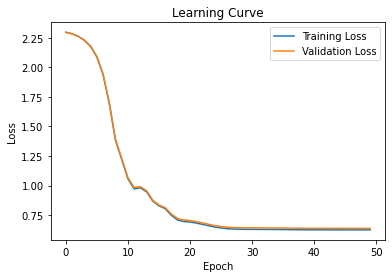

In [16]:
#Plot Learning Curves
import matplotlib.pyplot as plt
plt.plot(epoch_tr_losses, label = 'Training Loss')
plt.plot(epoch_val_losses, label = 'Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
#Test Set Accuracy
evall(test_loader, model)

Accuracy: 82.72 %


82.72

In [18]:
# evaluation(test_loader, model)

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def cal_confusion_matrix(dl, model):
    preds = torch.empty((0))
    labels = torch.empty((0))
    for batch in dl:
        ip, op = batch
        pred = model(ip)
        v, pred = torch.max(pred.data, 1)
        preds = torch.cat((preds, pred))
        labels = torch.cat((labels, op))
    
    ConfusionMatrixDisplay.from_predictions(labels, preds)
    plt.show()

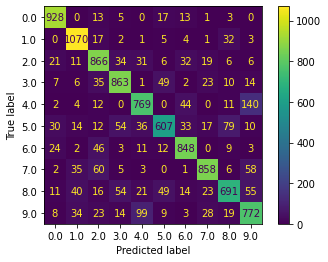

In [20]:
cal_confusion_matrix(test_loader, model)


## References

Therefore the following sources were referred to for this assignment (Mentioning all the sources at one place again):

- https://pytorch.org/docs/stable/index.html

- https://scikit-learn.org/0.21/documentation.html

- https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290

- https://github.com/satyajitghana/PadhAI-Course/blob/master/colab-notebooks/16_PyTorchCNN.ipynb

- https://androidkt.com/initialize-weight-bias-pytorch/

- https://discuss.pytorch.org/t/performing-mini-batch-gradient-descent-or-stochastic-gradient-descent-on-a-mini-batch/21235/5

- https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs

